In [1]:
import bilby
import lal
import lalsimulation as lalsim
import numpy as np
import matplotlib.pyplot as plt
#from pycbc.types import TimeSeries we might need this to produce the waveform?

In [2]:

srate=4096.*4.
deltaT=1./srate
m1=2*lal.MSUN_SI #in solar mass units
m2=30*lal.MSUN_SI


s1 = np.array([0.0,0.0,0.0]) #S1x, S1y, S1z
s2 = np.array([0.0,0.0,0.0])


dist = 1e8*lal.PC_SI
fmin = 40.
fmax = 400.
fref = fmax


phiRef = 0.0
iota = 0.1 #inclination?


emptydict = lal.CreateDict() #pass lambdaG in this empty dictionary?


hp1, hc1 = lalsim.SimInspiralChooseTDWaveform(m1, m2, s1[0], s1[1], s1[2], s2[0], s2[1], s2[2], dist, iota, phiRef, 0, 0, 0, deltaT, fmin, fref, emptydict, lalsim.IMRPhenomXHM)

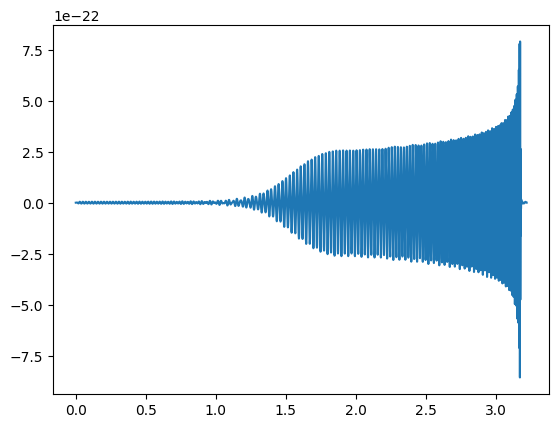

In [3]:
time = np.arange(0, len(hp1.data.data)) * deltaT
plt.plot(time, hp1.data.data)
#plt.plot(time, hc1.data.data)
plt.show()

TO-DO:Can we edit LALSimInspiral.C to add a new waveform model IMRPhenomZPHM that we can use here?

In [4]:
lalsim.SimInspiralWaveformParamsInsertPhenomZPHMLambdaG(emptydict, pow(10,15))

0

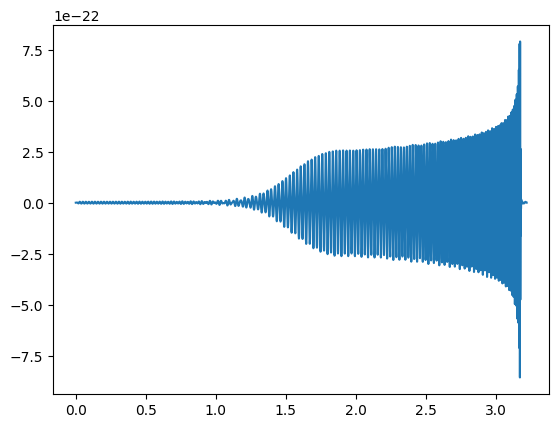

In [20]:
hp1, hc1 = lalsim.SimInspiralChooseTDWaveform(m1, m2, s1[0], s1[1], s1[2], s2[0], s2[1], s2[2], dist, iota, phiRef, 0, 0, 0, deltaT, fmin, fref, emptydict, lalsim.IMRPhenomXHM)
time = np.arange(0, len(hp1.data.data)) * deltaT
plt.plot(time, hp1.data.data)
#plt.plot(time, hc1.data.data)
plt.show()

In [5]:
 #hp1.data.data *= frequency_bounds

In [6]:
#lalsim.SimInspiralFD()


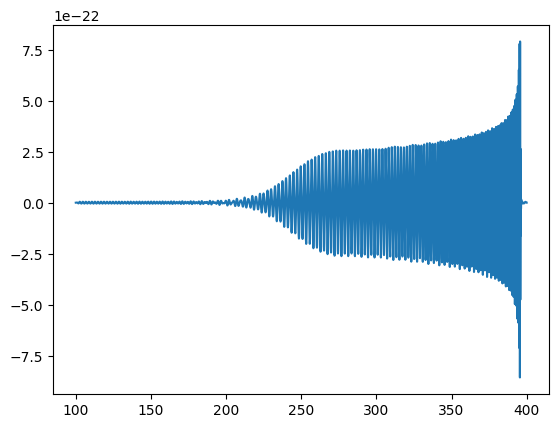

In [6]:
hp1data = np.array(hp1.data.data)
freq = np.linspace(100, fmax, num = len(hp1data)) 
#There must be a deltaF somewere 
plt.plot(freq, hp1data)

 

In [29]:
hp1.epoch
t = hp1.deltaT + (hp1.epoch.gpsSeconds + hp1.epoch.gpsNanoSeconds * 1e-9)
hp1.epoch.gpsSeconds


6.103515625e-05

In [6]:
#time_array = np.linspace(hp1.epoch, hp1.epoch + int(len(hp1.data.data) -1) * deltaT, deltaT)
#plt.plot(time_array, hp1.data.data, label='h+')
#plt.show()

In [8]:
#Transform the waveform into the time domain from LALSimInspiral.c
chirplen = 2 * (hp1.data.length - 1)
time = lal.CreateREAL8TimeSeries("H_PLUS", hp1.epoch, 0.0, deltaT, lal.StrainUnit, chirplen)
    
#lal.CreateREAL4TimeSeries('time', fmin,deltaT, len(hp1.data.data))

In [ ]:
 #need pycbc?
 #hp = TimeSeries(hp1.data.data[:], delta_t=hp1.deltaT, epoch=hp1.epoch)

In [ ]:
#Check this later
#if emptydict["lambdaG"]:
        #    lal.DictInsertUINT4Value(LALParams, "lambdaG", 1)

In [22]:

# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.
sampling_frequency = 2048.

# Specify the output directory and the name of the simulation.
outdir = 'outdir'
label = 'fast_tutorial'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=2.6, mass_2=23.2, a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=235., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108, lambdaG=1e15)

# Fixed arguments passed into the source model
waveform_arguments = dict(waveform_approximant='IMRPhenomZPHM',
                          reference_frequency=50., minimum_frequency=20.)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

# Set up a PriorDict, which inherits from dict.
# By default we will sample all terms in the signal models.  However, this will
# take a long time for the calculation, so for this example we will set almost
# all of the priors to be equall to their injected values.  This implies the
# prior is a delta function at the true, injected value.  In reality, the
# sampler implementation is smart enough to not sample any parameter that has
# a delta-function prior.
# The above list does *not* include mass_1, mass_2, theta_jn and luminosity
# distance, which means those are the parameters that will be included in the
# sampler.  If we do nothing, then the default priors get used.
priors = bilby.gw.prior.BBHPriorDict()
priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=injection_parameters['geocent_time'] - 1,
    maximum=injection_parameters['geocent_time'] + 1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'geocent_time', 'phase', 'lambdaG']:
    priors[key] = injection_parameters[key]
priors['lambdaG'] = bilby.core.prior.Uniform(minimum=1e15, maximum=1e19, name='lambdaG', latex_label='$\lambda_G$')
#priors['redshift'] = bilby.core.prior.Uniform(0,1)

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator)

# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='Nessai', npoints=1000,
    injection_parameters=injection_parameters, outdir=outdir, label=label)

lambdaG_sample = result.posterior['lambdaG']
print(lambdaG_sample[:10])
lambdaG_log = np.log10(lambdaG_sample)
print(lambdaG_log[:10])

result.posterior['lambdaG'] = lambdaG_log
print(result.posterior['lambdaG'])


# Make a corner plot.
result.plot_corner()

10:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


AttributeError: module 'lalsimulation' has no attribute 'SimInspiralWaveformParamsInsertZPHMLambdaG'